In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS08c-008.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (6417737, 4)
X_s shape: (6417737, 14)
X_v shape: (6417737, 14)
T shape: (6417737, 10)
A shape: (6417737, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


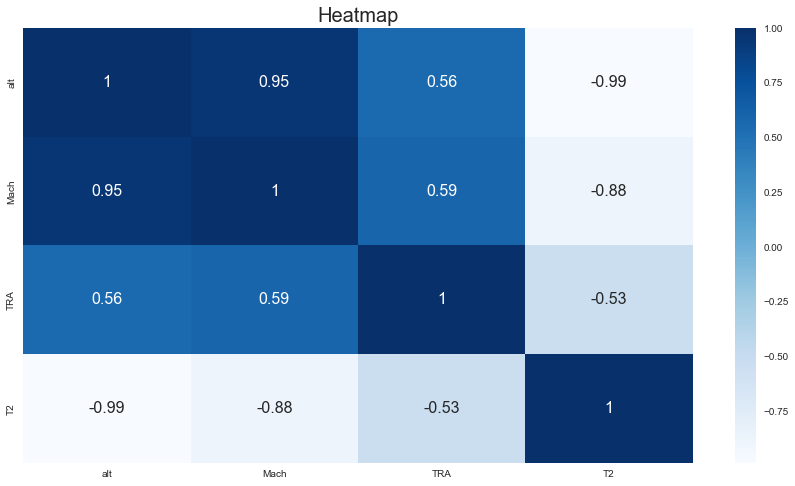

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,623.703671,1497.961251,1905.748847,1297.155519,19.670090,14.300144,19.969635,25.048474,419.892878,426.471104,16.313650,2211.390744,8781.162212,5.065123,1.0,3008.0,0.350658,78.222099,520.434430
1,623.705184,1497.934281,1905.456402,1296.867930,19.667190,14.297018,19.966690,25.046456,419.823527,426.404057,16.307995,2211.587204,8781.150874,5.062908,1.0,3014.0,0.350658,78.222099,520.413179
2,623.519509,1496.404431,1901.169747,1294.120319,19.652891,14.298894,19.952174,25.019703,418.270660,424.864063,16.272197,2209.090201,8776.737611,5.030290,1.0,3022.0,0.351540,77.782646,520.445512
3,622.971839,1494.224129,1896.979472,1292.042214,19.613403,14.292765,19.912084,24.946426,416.112060,422.692585,16.238231,2204.109329,8769.890552,4.993672,1.0,3027.0,0.351036,77.255310,520.391947
4,622.443958,1491.877763,1892.301787,1289.679165,19.579963,14.295446,19.878135,24.877265,413.829157,420.399250,16.202249,2198.560497,8762.544928,4.954148,1.0,3038.0,0.352233,76.640076,520.438472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417732,580.874265,1336.311772,1632.337827,1190.588776,16.690469,13.544327,16.944638,19.784800,277.279021,282.288846,14.675413,1813.128361,8239.482286,2.887059,10.0,3015.0,0.212625,42.275089,512.509382
6417733,581.322145,1338.902762,1638.919473,1194.172451,16.710928,13.540672,16.965410,19.831510,279.330162,284.327816,14.706590,1819.208824,8247.658552,2.922004,10.0,3012.0,0.211302,42.890320,512.464381
6417734,581.779327,1339.878239,1638.680086,1192.984508,16.731720,13.540742,16.986518,19.878398,279.972724,285.006436,14.702330,1824.289040,8251.821581,2.925543,10.0,3009.0,0.210924,43.153988,512.459609
6417735,581.944856,1340.229350,1638.928107,1192.902754,16.741151,13.544101,16.996092,19.896491,280.223017,285.263575,14.704674,1825.730304,8253.061057,2.927910,10.0,3006.0,0.211428,43.241879,512.490731


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06,6.417737e+06
mean,5.669775e+02,1.330315e+03,1.641937e+03,1.125021e+03,1.239407e+01,9.622461e+00,1.258281e+01,1.534308e+01,2.300770e+02,2.340658e+02,9.568624e+00,1.972736e+03,8.233736e+03,2.469597e+00,5.023070e+00,1.720172e+04,5.579765e-01,6.262110e+01,4.864055e+02
std,2.049321e+01,6.603150e+01,1.192213e+02,6.113825e+01,2.807286e+00,2.358796e+00,2.850037e+00,3.347895e+00,5.676579e+01,5.756300e+01,2.687244e+00,1.797385e+02,2.185341e+02,7.484002e-01,2.835982e+00,7.976663e+03,1.186348e-01,1.791639e+01,1.950557e+01
min,4.841978e+02,1.073475e+03,1.093388e+03,7.918375e+02,5.915453e+00,4.373175e+00,6.005536e+00,6.911965e+00,8.037893e+01,8.213415e+01,4.127421e+00,1.469810e+03,7.371819e+03,5.953975e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02
25%,5.524169e+02,1.289351e+03,1.567816e+03,1.083616e+03,1.008101e+01,7.652991e+00,1.023453e+01,1.265964e+01,1.884951e+02,1.918763e+02,7.336865e+00,1.863519e+03,8.100885e+03,1.946001e+00,3.000000e+00,1.062900e+04,4.706730e-01,4.886684e+01,4.709512e+02
50%,5.638955e+02,1.325949e+03,1.649051e+03,1.113382e+03,1.217980e+01,9.389110e+00,1.236528e+01,1.505006e+01,2.158649e+02,2.197362e+02,9.223301e+00,2.024390e+03,8.225344e+03,2.261296e+00,5.000000e+00,1.742900e+04,5.740560e-01,6.881787e+01,4.868532e+02
75%,5.798562e+02,1.367756e+03,1.716921e+03,1.160944e+03,1.456970e+01,1.160102e+01,1.479157e+01,1.771488e+01,2.618098e+02,2.663188e+02,1.160071e+01,2.118371e+03,8.360050e+03,2.844374e+00,7.000000e+00,2.397000e+04,6.509160e-01,7.830999e+01,5.034165e+02
max,6.330751e+02,1.540146e+03,1.991300e+03,1.369585e+03,2.032231e+01,1.568410e+01,2.063178e+01,2.627326e+01,4.557684e+02,4.616990e+02,1.676720e+01,2.290648e+03,8.887342e+03,5.639740e+00,1.000000e+01,3.503300e+04,7.492590e-01,8.876890e+01,5.343834e+02


1.9182217005837854e-15 0.9999999999999976
(6417737, 18)


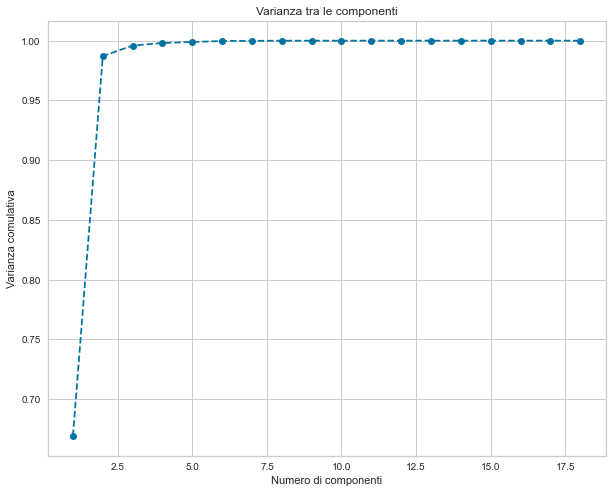

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

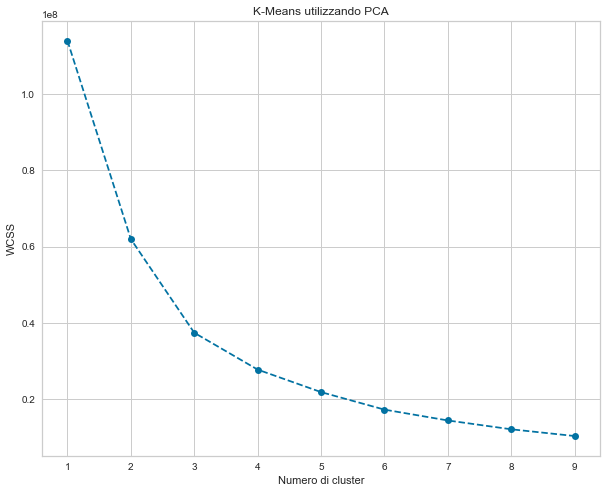

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

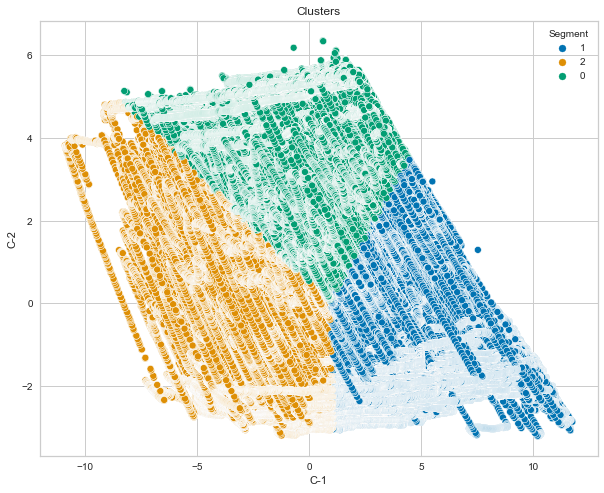

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,623.703671,1497.961251,1905.748847,1297.155519,19.670090,14.300144,19.969635,25.048474,419.892878,426.471104,...,5.065123,1.0,3008.0,0.350658,78.222099,520.434430,10.370992,-1.769413,1,1
1,623.705184,1497.934281,1905.456402,1296.867930,19.667190,14.297018,19.966690,25.046456,419.823527,426.404057,...,5.062908,1.0,3014.0,0.350658,78.222099,520.413179,10.365851,-1.768948,1,1
2,623.519509,1496.404431,1901.169747,1294.120319,19.652891,14.298894,19.952174,25.019703,418.270660,424.864063,...,5.030290,1.0,3022.0,0.351540,77.782646,520.445512,10.298810,-1.715055,1,1
3,622.971839,1494.224129,1896.979472,1292.042214,19.613403,14.292765,19.912084,24.946426,416.112060,422.692585,...,4.993672,1.0,3027.0,0.351036,77.255310,520.391947,10.209061,-1.647187,1,1
4,622.443958,1491.877763,1892.301787,1289.679165,19.579963,14.295446,19.878135,24.877265,413.829157,420.399250,...,4.954148,1.0,3038.0,0.352233,76.640076,520.438472,10.114495,-1.572931,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417732,580.874265,1336.311772,1632.337827,1190.588776,16.690469,13.544327,16.944638,19.784800,277.279021,282.288846,...,2.887059,10.0,3015.0,0.212625,42.275089,512.509382,4.454953,3.127041,1,1
6417733,581.322145,1338.902762,1638.919473,1194.172451,16.710928,13.540672,16.965410,19.831510,279.330162,284.327816,...,2.922004,10.0,3012.0,0.211302,42.890320,512.464381,4.549232,3.040949,1,1
6417734,581.779327,1339.878239,1638.680086,1192.984508,16.731720,13.540742,16.986518,19.878398,279.972724,285.006436,...,2.925543,10.0,3009.0,0.210924,43.153988,512.459609,4.574990,3.016269,1,1
6417735,581.944856,1340.229350,1638.928107,1192.902754,16.741151,13.544101,16.996092,19.896491,280.223017,285.263575,...,2.927910,10.0,3006.0,0.211428,43.241879,512.490731,4.586939,3.006499,1,1


In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [11]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

1.2145937672084394e-15 1.0000000000000002
(1512016, 19)
-1.680762379202047e-15 1.0000000000000004
(1744248, 19)
-9.307378456461954e-16 1.0000000000000009
(3161473, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,560.808693,1267.633385,1501.788253,1094.273019,13.806555,11.586692,14.016807,16.205525,210.434389,214.693046,11.269090,1714.546628,8018.150672,2.036406,5.552039,10276.631563,0.450558,36.733649,502.216148,0.0
mean,593.628570,1408.686188,1764.625620,1203.579060,15.371083,11.571551,15.605160,19.312529,305.748678,310.764133,12.167564,2087.239657,8489.448014,3.462911,5.463197,10793.435561,0.481031,69.571824,502.863684,1.0
mean,555.223844,1317.054956,1641.275105,1096.385279,10.076051,7.607690,10.229493,12.740571,197.721752,201.015123,7.321467,2033.043873,8195.761472,2.128745,4.527257,24049.322278,0.651803,71.167270,469.763564,2.0


Text(0, 0.5, 'Flight Class # [-]')

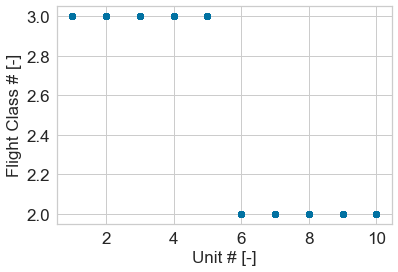

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [13]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2}

In [14]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,623.703671,1497.961251,1905.748847,1297.155519,19.670090,14.300144,19.969635,25.048474,419.892878,426.471104,...,1.0,3008.0,0.350658,78.222099,520.434430,10.370992,-1.769413,1,1,3
1,623.705184,1497.934281,1905.456402,1296.867930,19.667190,14.297018,19.966690,25.046456,419.823527,426.404057,...,1.0,3014.0,0.350658,78.222099,520.413179,10.365851,-1.768948,1,1,3
2,623.519509,1496.404431,1901.169747,1294.120319,19.652891,14.298894,19.952174,25.019703,418.270660,424.864063,...,1.0,3022.0,0.351540,77.782646,520.445512,10.298810,-1.715055,1,1,3
3,622.971839,1494.224129,1896.979472,1292.042214,19.613403,14.292765,19.912084,24.946426,416.112060,422.692585,...,1.0,3027.0,0.351036,77.255310,520.391947,10.209061,-1.647187,1,1,3
4,622.443958,1491.877763,1892.301787,1289.679165,19.579963,14.295446,19.878135,24.877265,413.829157,420.399250,...,1.0,3038.0,0.352233,76.640076,520.438472,10.114495,-1.572931,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417732,580.874265,1336.311772,1632.337827,1190.588776,16.690469,13.544327,16.944638,19.784800,277.279021,282.288846,...,10.0,3015.0,0.212625,42.275089,512.509382,4.454953,3.127041,1,1,2
6417733,581.322145,1338.902762,1638.919473,1194.172451,16.710928,13.540672,16.965410,19.831510,279.330162,284.327816,...,10.0,3012.0,0.211302,42.890320,512.464381,4.549232,3.040949,1,1,2
6417734,581.779327,1339.878239,1638.680086,1192.984508,16.731720,13.540742,16.986518,19.878398,279.972724,285.006436,...,10.0,3009.0,0.210924,43.153988,512.459609,4.574990,3.016269,1,1,2
6417735,581.944856,1340.229350,1638.928107,1192.902754,16.741151,13.544101,16.996092,19.896491,280.223017,285.263575,...,10.0,3006.0,0.211428,43.241879,512.490731,4.586939,3.006499,1,1,2


In [15]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       2     795455
1       3     716561
totale cluster 0 : 1512016
cluster 1
   Classe  Conteggio
0       2     880315
1       3     863933
totale cluster 1 : 1744248
cluster 2
   Classe  Conteggio
0       3    2189080
1       2     972393
totale cluster 2 : 3161473


In [16]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [17]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 3001.0
max: 19964.0


In [18]:
df_segm_pca_kmeans['cycle'] = df_A['cycle'].values
for i in range(0,3):
    filter_cluster = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == i]
    if filter_cluster['alt'].min() >= 10000:
        print('Saving Cluster',i)
        filename_out = filename.replace('.h5','')
        filename_out += "_clr_" + str(i) + ".csv"
        df_X_s_u_c_mean = filter_cluster.groupby(['unit', 'cycle']).mean()
        df_X_s_u_c_mean = pd.DataFrame(df_X_s_u_c_mean).reset_index()
        df_X_s_u_c_mean.to_csv("./dataset_csv/"+filename_out,index=False)

Saving Cluster 2
